# Analysis of GoFast Users' Data and Hypothesis Testing

We were provided with data about some users of GoFast from several cities, as well as their trips. In this study, we will analyze the data and test some hypotheses that could help the business grow and answer the question: are subscription users more profitable for the company?

To make trips around the city, GoFast users use a mobile application. The service can be used:

- Without a subscription:
    - No subscription fee;
    - The cost of one minute of a trip is 8 rubles;
    - The cost of starting a trip is 50 rubles;
- With the Ultra subscription:
    - Subscription fee is 199 rubles per month;
    - The cost of one minute of a trip is 6 rubles;
    - The cost of starting a trip is free.

The provided data includes:
- Information about users (users_go.csv), which contains a unique user identifier (user_id), username (name), age (age), city (city), subscription type (free, ultra) (subscription_type);
- Information about their trips (rides_go.csv), which includes the unique user identifier (user_id), the distance traveled during the session (distance), the session duration (duration), and the date of the trip (date);
- Subscription details (subscriptions_go.csv), which includes the subscription type (subscription_type), the cost per minute of the trip for that subscription (minute_price), the start ride cost (start_ride_price), and the monthly payment (subscription_fee).

The structure of the research will be as follows:

1. In the first step of the research, we will load the data and perform a shallow data check.
2. In the second step, we will perform a deeper data quality check, focusing on data types, missing values, and duplicates.
3. In the third step, we will conduct an exploratory data analysis, looking for unusual patterns, artifacts, and errors in the data, and create visualizations.
4. In the fourth step, we will combine the three dataframes into one for easier further analysis.
5. In the fifth step, we will calculate the revenue for subscription and non-subscription users.
6. In the sixth step, we will review and test several business hypotheses.
7. In the final step, we will examine the distributions and make a general conclusion from the study.

In [12]:
import pandas as pd

In [13]:
import numpy as np

In [14]:
import matplotlib.pyplot as plt

#### Data Upload


Let's load the data from the CSV files into a dataframe using the pandas library. We will then examine the first few rows of each dataset.

In [15]:
try:
    data_users = pd.read_csv('/datasets/users_go.csv')
    data_rides = pd.read_csv('/datasets/rides_go.csv')
    data_subs = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    data_users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
    data_rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
    data_subs = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

In [16]:
display(data_users.head())
display(data_users.info())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

The data looks good – the data types match the column names and their content, there are no missing values, and we will check for duplicates later.

In [17]:
display(data_rides.head())
display(data_rides.info())

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

The data looks good except for the date, which has the data type 'object'.

In [18]:
display(data_subs.head())
display(data_subs.info())

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


None

Data looks good.

#### Data Preprocessing

When we first review the data and their types, we can observe one discrepancy that needs to be addressed: in the rides dataframe (data_rides), the date data type is 'object'. We will convert it to the datetime64 format using the to_datetime() method and then verify it with the info() method.

In [19]:
data_rides['date'] = pd.to_datetime(
    data_rides['date'].astype(str), format='ISO8601')

In [20]:
display(data_rides.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


None

We will add a column named "month" to the rides dataframe (data_rides). To do this, we will extract the month name from the date column by converting the time to the DatetimeIndex class and applying the month attribute.

In [21]:
data_rides['month'] = pd.DatetimeIndex(data_rides['date']).month

In [22]:
display(data_rides.head())

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


We will find and examine the missing values in the columns. To do this, we will use the combination of the methods .isna().sum() for each dataframe.

In [23]:
data_users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

There are no missing values in the data_users dataframe.

In [24]:
data_rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

There are no missing values in the data_rides dataframe.

In [25]:
data_subs.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

There are no missing values in the data_subs dataframe.

Let's look for explicit and implicit duplicates. For explicit duplicates, we'll use the combination of .duplicated().sum(), and for implicit duplicates, we'll examine individual columns using the .unique() method.

In [26]:
data_users.duplicated().sum()

np.int64(31)

Let's take a closer look at the duplicates. We will extract the rows from the dataframe where duplicates occur using logical indexing with the .duplicated() method. We observe identical rows in the dataframe, which are explicit duplicates. We will remove the duplicate rows using the drop_duplicates() method and save the changes in the original dataframe.

In [27]:
duplicates = data_users[data_users.duplicated(keep=False)]
duplicates.sort_values(by='name')

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
292,293,Агата,26,Краснодар,ultra
1545,807,Александр,28,Екатеринбург,free
806,807,Александр,28,Екатеринбург,free
1553,121,Алина,25,Пятигорск,ultra
...,...,...,...,...,...
1563,47,Юрий,28,Тюмень,ultra
808,809,Юрий,26,Сочи,free
1561,809,Юрий,26,Сочи,free
306,307,Ясмина,19,Краснодар,ultra


In [28]:
data_users.drop_duplicates(subset=['user_id', 'name'],inplace=True)

In [29]:
data_users.duplicated().sum()

np.int64(0)

In [30]:
data_rides.duplicated().sum()

np.int64(0)

In [31]:
data_subs.duplicated().sum()

np.int64(0)

Implicit duplicates may occur in the city column of the data_users dataframe. Let's look at all the unique values in this column.

In [32]:
data_users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

It can be confidently said that there are no duplicates or missing values in the provided dataframes.

For further work, we will round the numbers in the "duration" column to the next whole number.

In [33]:
data_rides['duration'] = np.ceil(data_rides['duration'])

#### Exploratory Data Analysis

As part of familiarizing ourselves with the dataframe, let's try to visualize the general information about users and rides. We will create separate histograms using the `.hist()` method for each of the following parameters:

- Frequency of cities;
- Proportion of users with and without a subscription;
- Age of users;
- Distance traveled by users in a single ride;
- Duration of rides.

In [34]:
city_counts = data_users['city'].value_counts()
city_counts

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

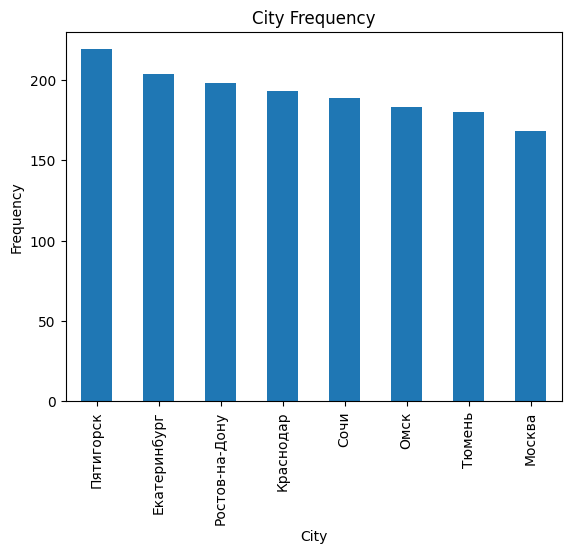

In [35]:
city_counts.plot.bar()
plt.title('City Frequency')
plt.xlabel('City')
plt.ylabel('Frequency')
plt.show()

In [36]:
max_city = city_counts.idxmax()
display(f'City with the highest frequency: {max_city} {city_counts[max_city]} times')

'City with the highest frequency: Пятигорск 219 times'

In [37]:
min_city = city_counts.idxmin()
display(f'City with the lowest frequency: {min_city} {city_counts[min_city]} times')

'City with the lowest frequency: Москва 168 times'

In [38]:
subs_counts = data_users['subscription_type'].value_counts()
subs_counts

subscription_type
free     835
ultra    699
Name: count, dtype: int64

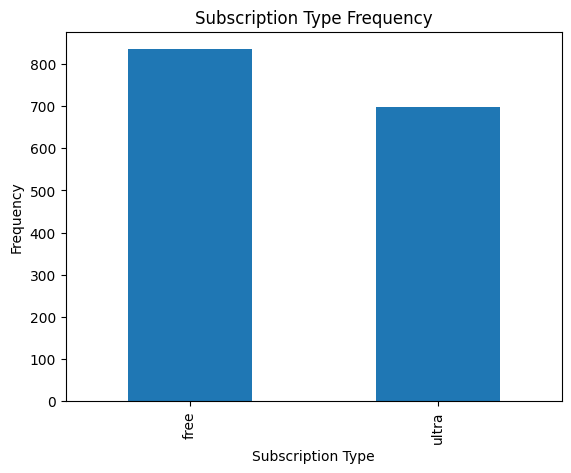

In [39]:
subs_counts.plot.bar()
plt.title('Subscription Type Frequency')
plt.xlabel('Subscription Type')
plt.ylabel('Frequency')
plt.show()

In [40]:
part = len(data_users.query("subscription_type == 'free'")) / len(data_users.query("subscription_type == 'ultra'"))
display(f'For each user with a subscription, there are {round(part, 2)} users without a subscription.')

'For each user with a subscription, there are 1.19 users without a subscription.'

In [41]:
procent_free = (len(data_users.query("subscription_type == 'free'")) / len(data_users)) * 100
procent_ultra = 100 - procent_free
display(f'Users without subscription: {round(procent_free, 2)}%, users with Ultra subscription: {round(procent_ultra, 2)}%')

'Users without subscription: 54.43%, users with Ultra subscription: 45.57%'

The number of users with a subscription is around 700, while the number of users without a subscription is around 800.

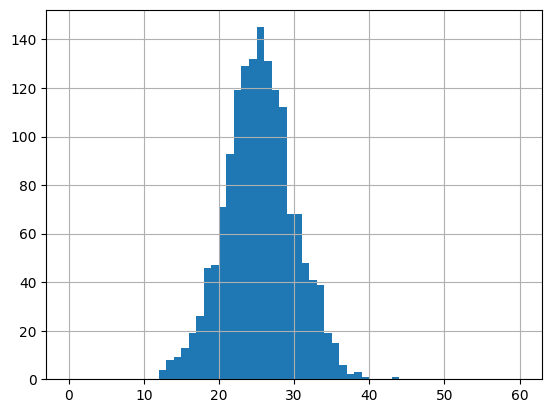

In [42]:
data_users['age'].hist(bins=60,range=(0,60));

In [43]:
data_users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

The majority of users are between the ages of 22 and 28, and the age range of all users spans from 12 to 43 years. These data seem normal.

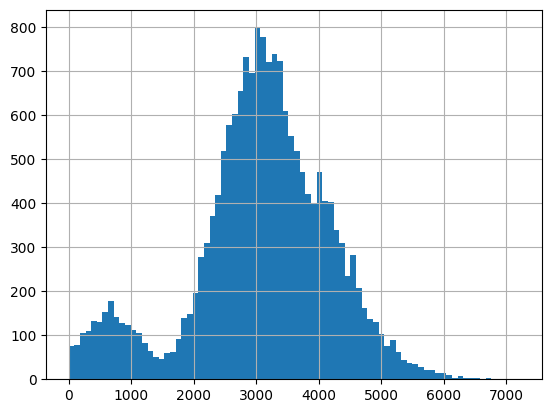

In [44]:
data_rides['distance'].hist(bins=80);

In [45]:
data_rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Most scooter rides have a distance ranging from approximately 2543 to 3776 meters, while the distances vary from less than one meter to over 7 kilometers. These data seem normal.

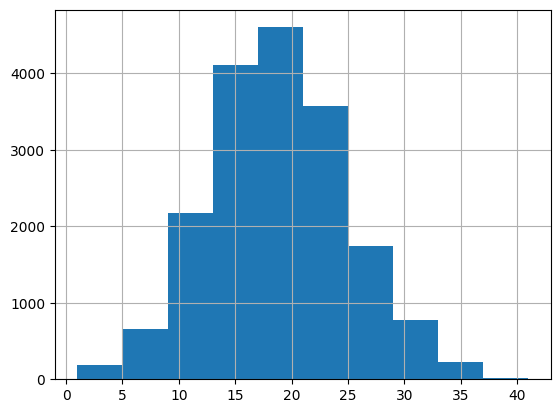

In [46]:
data_rides['duration'].hist();

In [47]:
data_rides['duration'].describe()

count    18068.000000
mean        18.303520
std          6.094928
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

Most scooter rides last between approximately 13.60 to 21.72 minutes, while the duration of rides varies from 0.50 to 40.82 minutes. These data seem normal.

#### Data Union

To avoid working with multiple data sources, we will combine all the dataframes into one using the merge() method. First, we will merge data_users and data_rides on the column 'id'. Later, we will add data_subs to the already merged table using the column 'subscription_type'.

In [48]:
data_uers_riders = data_users.merge(data_rides,on='user_id',how='outer')

In [49]:
display(data_uers_riders.head())

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8


In [50]:
data_uers_riders.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
dtype: int64

In [51]:
data = data_uers_riders.merge(data_subs,on='subscription_type',how='outer')

In [52]:
display(data.head())

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,700,Айдар,22,Омск,free,2515.690719,15.0,2021-01-02,1,8,50,0
1,700,Айдар,22,Омск,free,846.932642,17.0,2021-02-01,2,8,50,0
2,700,Айдар,22,Омск,free,4004.434142,21.0,2021-02-04,2,8,50,0
3,700,Айдар,22,Омск,free,1205.911290,10.0,2021-02-10,2,8,50,0
4,700,Айдар,22,Омск,free,3047.379435,18.0,2021-02-14,2,8,50,0


In [53]:
data_uers_riders.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
dtype: int64

In [54]:
data_uers_riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2), object(3)
memory usage: 1.2+ MB


For easier handling, we will split this dataframe into two: users with a subscription and users without a subscription.

In [55]:
data_free = data[data['subscription_type'] != 'ultra']

In [56]:
display(data_free.head())

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,700,Айдар,22,Омск,free,2515.690719,15.0,2021-01-02,1,8,50,0
1,700,Айдар,22,Омск,free,846.932642,17.0,2021-02-01,2,8,50,0
2,700,Айдар,22,Омск,free,4004.434142,21.0,2021-02-04,2,8,50,0
3,700,Айдар,22,Омск,free,1205.911290,10.0,2021-02-10,2,8,50,0
4,700,Айдар,22,Омск,free,3047.379435,18.0,2021-02-14,2,8,50,0


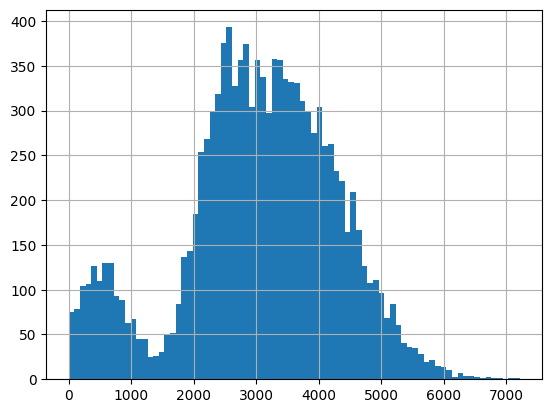

In [57]:
data_free['distance'].hist(bins=80);

In [58]:
data_free['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

In this case, the mean (3045.495282) and the median (3114.648465) are quite close to each other, indicating that the data distribution is symmetric, which is exactly what we observe.

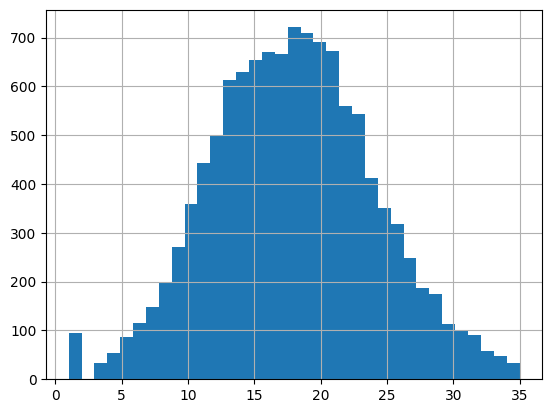

In [59]:
data_free['duration'].hist(bins=35);

In [60]:
data_free['duration'].describe()

count    11568.000000
mean        17.890992
std          6.330250
min          1.000000
25%         13.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64

Here we observe an almost perfect match between the median and the mean—the graph takes the shape of a normal distribution, with the most frequent value around 18 minutes and a standard deviation of 6 minutes.

In [61]:
data_ultra = data[data['subscription_type'] != 'free']

In [62]:
display(data_ultra.head())

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
11568,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
11569,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
11570,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
11571,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
11572,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199


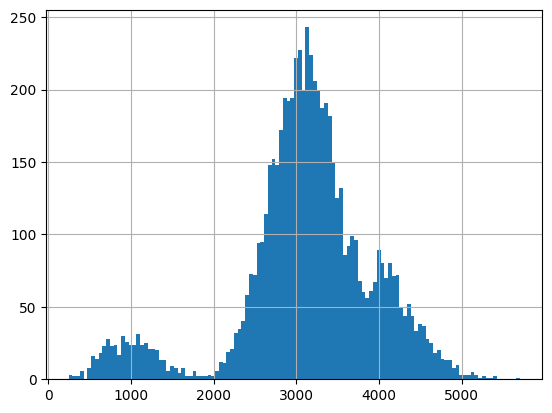

In [63]:
data_ultra['distance'].hist(bins=120);

In [64]:
data_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

The distribution resembles the shape of the values for users without a subscription. The mean and median are also close to each other—3115 and 3560 minutes, respectively. The standard deviation is lower.

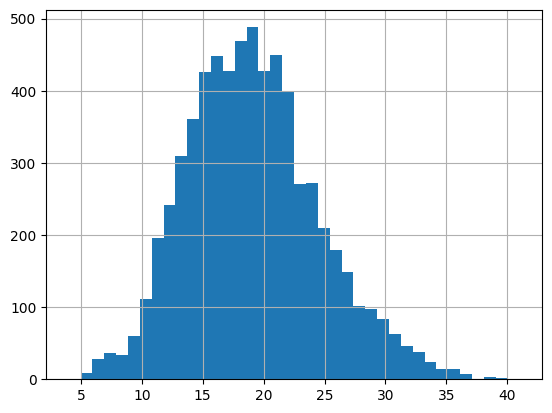

In [65]:
data_ultra['duration'].hist(bins=38);

In [66]:
data_ultra['duration'].describe()

count    6500.000000
mean       19.037692
std         5.577439
min         4.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        41.000000
Name: duration, dtype: float64

The mean and median are almost identical, both around 19 minutes, which is one minute more than for users without a subscription.

#### Revenue Сalculation

We will create a dataframe with aggregated trip data based on the merged dataframe from step 4. Using a combination of the `.groupby()` and `.agg()` methods, we will calculate the total distance, the number of trips, and the total time for each user for each month.

In [67]:
data_agg = data.groupby(['user_id', 'month','subscription_type']).agg({
    'distance': 'sum',           
    'duration': ['count', 'sum']
}).reset_index()

In [68]:
data_agg.columns = ['user_id', 'month','subscription_type','total_distance', 'total_trips', 'total_duration']

In [69]:
display(data_agg.head(10))

,user_id,month,subscription_type,total_distance,total_trips,total_duration
0,1,1,ultra,7027.511294,2,42.0
1,1,4,ultra,754.159807,1,7.0
2,1,8,ultra,6723.470560,2,46.0
3,1,10,ultra,5809.911100,2,32.0
4,1,11,ultra,7003.499363,3,56.0
5,1,12,ultra,6751.629942,2,28.0
6,2,3,ultra,10187.723006,3,63.0
7,2,4,ultra,6164.381824,2,40.0
8,2,6,ultra,3255.338202,1,14.0
9,2,7,ultra,6780.722964,2,48.0


We will also add a column to this dataframe with the monthly revenue generated by each user.

In [70]:
def month_revenue(row):
    sub = row['subscription_type']
    trip = row['total_trips']
    duar = row['total_duration']
    
    if sub == 'free':
        return 50*trip + 8*duar
    if sub == 'ultra':
        return 0*trip + 6*duar + 199
    return 'smth wrong, please, check code'

In [71]:
data_agg['month_revenue'] = data_agg.apply(month_revenue, axis=1)

In [72]:
display(data_agg.head())

,user_id,month,subscription_type,total_distance,total_trips,total_duration,month_revenue
0,1,1,ultra,7027.511294,2,42.0,451.0
1,1,4,ultra,754.159807,1,7.0,241.0
2,1,8,ultra,6723.470560,2,46.0,475.0
3,1,10,ultra,5809.911100,2,32.0,391.0
4,1,11,ultra,7003.499363,3,56.0,535.0


#### Hypothesis Testing

We will test a couple of hypotheses on the resulting dataframes.

Do users with a subscription spend more time on trips?

- Null hypothesis (H0) – the average trip duration for users with the "Ultra" subscription is equal to the average trip duration for users with free access.
- Alternative hypothesis (H1) – the average trip duration for users with the "Ultra" subscription is greater than the average trip duration for users with free access.

In [73]:
from scipy import stats as st

In [74]:
alpha = 0.05  # setting the significance level

results = st.ttest_ind(data_ultra['duration'], data_free['duration'], alternative='greater')  # performing t-test for two samples, using the one-tailed hypothesis "greater"

print(f'p-value: {results.pvalue}')

# checking p-value
if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('No grounds to reject the null hypothesis')

p-value: 2.495945372073663e-34
Reject the null hypothesis


Since the p-value is significantly smaller than the significance level (0.05), we reject the null hypothesis. This means that the average trip duration for users with the "Ultra" subscription is greater than the average trip duration for users with free access.

Can we say that the distance traveled by users with a subscription in a single trip does not exceed 3130 meters?

- Null hypothesis (H0) – the average distance traveled by users with a subscription in a single trip is equal to the optimal distance of 3130 meters.
- Alternative hypothesis (H1) – the average distance traveled by users with a subscription in a single trip is greater than the optimal 3130 meters.

In [75]:
compare_value = 3130  # Can we say that the distance traveled by users with a subscription in a single trip does not exceed 3130 meters?

alpha = 0.05  # setting the significance level

results = st.ttest_1samp(data_ultra['distance'], compare_value, alternative='greater') 

print(f'p-value: {results.pvalue}')

# checking p-value
if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('No grounds to reject the null hypothesis')

p-value: 0.9195368847849785
No grounds to reject the null hypothesis


The p-value is greater than the significance level (0.05), so we cannot reject the null hypothesis. Thus, based on the available data, there is insufficient evidence to claim that the average distance exceeds the optimal 3130 meters.

The p-value is greater than the significance level (0.05), so we cannot reject the null hypothesis. Thus, based on the available data, there is insufficient evidence to claim that the average distance exceeds the optimal 3130 meters.

- Null hypothesis (H0) – the average monthly revenue from subscription users is equal to the average monthly revenue from non-subscription users.
- Alternative hypothesis (H1) – the average monthly revenue from subscription users exceeds the average monthly revenue from non-subscription users.

In [76]:
alpha = 0.05  # setting the significance level

results = st.ttest_ind(data_agg[data_agg['subscription_type'] == 'ultra']['month_revenue'], data_agg[data_agg['subscription_type'] == 'free']['month_revenue'], alternative='greater')  # performing t-test for two samples, using the one-tailed hypothesis "greater"

print(f'p-value: {results.pvalue}')

# checking p-value
if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('No grounds to reject the null hypothesis')


p-value: 1.8850394384715216e-31
Reject the null hypothesis


The p-value is below the significance level (0.05), so we can reject the null hypothesis. Therefore, the average monthly revenue from subscription users exceeds the average monthly revenue from non-subscription users.

The technical team of the service has updated the servers that the mobile app interacts with. They hope that as a result, the number of support requests has significantly decreased. A certain file contains data for each user on the number of support requests before and after the update. Which test would you need to check this hypothesis?

For this hypothesis, a paired t-test (also called a dependent t-test) would be appropriate, as you are comparing the same group of users' behavior (number of requests) before and after the update. This test will help you determine if there is a significant difference in the number of support requests before and after the update for the same users.

#### Distributions

A promotion is being conducted where promo codes for a free one-month subscription will be distributed, and at least 100 existing customers must extend their subscription. After the subscription period ends, users can either cancel or extend the subscription by making the corresponding payment. This promotion was previously conducted, and it was found that 10% of users extend their subscription after the free trial period. Determine the minimum number of promo codes that need to be sent out so that the probability of not meeting the goal is approximately 5%. Identify the parameters of the distribution that describe this situation, plot the distribution, and provide an answer to the question about the number of promo codes.

The marketing department is sending push notifications to customers in the mobile app. Customers may either open or ignore them. It is known that approximately 40% of the recipients open the notifications. The department plans to send out 11 million notifications. Using approximation, plot an approximate distribution graph and estimate the probability that no more than 399,500 users will open the notification.

As part of the research, we:

- Extracted data on users, rides, and subscriptions
- Conducted thorough data validation – changed data types and removed duplicates
- By plotting graphs, we gained insights into some quantitative and qualitative characteristics of the data, such as:
  - The city with the highest frequency – Pyatigorsk
  - The city with the lowest frequency – Moscow
  - 54.43% of users do not have a subscription, while 45.57% have subscriptions
  - The majority of users are between the ages of 22 and 28
  - Most scooter rides are between approximately 2543 and 3776 meters long (the distribution for users with and without subscriptions is very similar)
  - Most scooter rides last between approximately 13.60 and 21.72 minutes (the average duration for users with a subscription is one minute longer)
- By combining 3 different dataframes, we created a unified base for hypothesis testing
- Added a new column – revenue – for both subscribed and non-subscribed users
- In the sixth step, we examined and tested several hypotheses for the business and came to the following conclusions:
  - The average ride duration for subscribed users is greater than for non-subscribed users.
  - There is insufficient evidence to claim that the average distance exceeds the optimal wear-and-tear distance of 3130 meters.
  - The average monthly revenue from subscribed users is higher than from non-subscribed users.

Based on the analysis, the following conclusions can be drawn:

- Subscribed users show greater engagement, reflected in the longer duration of their rides.
- There is no significant evidence that subscribed users exceed the optimal wear-and-tear distance.
- Financial analysis showed that subscribed users generate significantly more revenue for the company compared to non-subscribed users.

Thus, it can be concluded that subscribed users are more profitable for GoFast, as they spend more time on rides and bring in more revenue. This confirms the feasibility and effectiveness of implementing and promoting subscription models to increase company revenue and enhance customer loyalty.